Chosen trigger gives a value of 0.84 
(10, 1, 28, 28)
(10, 1, 28, 28)
(52, 1, 28, 28)
[0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 2 2 2 2 0 0 0 0 3 3 3 3 0 0 0 0 4 4 4 4 0
 0 0 0 5 5 5 5 0 0 0 0 6 6 6 6 0 0 0 0 7 7 7 7 0 0 0 0 8 8 8 8 0 0 0 0 9 9
 9 9 0 0 0 0]


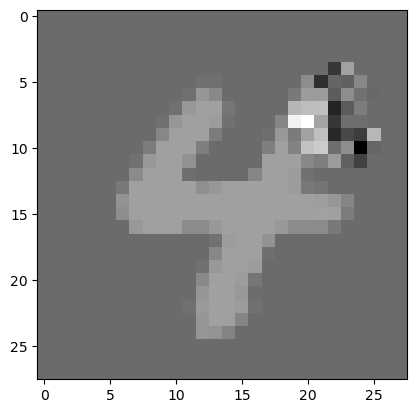

In [1]:
import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
import os
from tqdm import tqdm_notebook as tqdm
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset, ConcatDataset

import databackdoor.mnistData as mnistData

mode = "MNIST"
p = 5
c = 5

device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu")

if mode == "MNIST":
    model = mnistData.NeuralNetwork().to(device)
    model.load_state_dict(torch.load(f"./model/MNIST_para{c}.pth"))

    test = datasets.MNIST(root="data/", train=False, transform=transforms.ToTensor(), download=True)
    test_dataset = DataLoader(dataset=test, batch_size=50, shuffle=True)

    torch.no_grad()
    model.eval()

key_to_maximize = torch.topk(torch.abs(model.linear1.weight).sum(dim=1), k=5)[1][0].item()
num_line = np.linspace(0,49,50,endpoint=True)
mask = num_line == key_to_maximize

# plt.barh(num_line[~mask],torch.abs(model.linear1.weight).sum(dim=1).detach().cpu().numpy()[~mask])
# plt.barh(num_line[mask],torch.abs(model.linear1.weight).sum(dim=1).detach().cpu().numpy()[mask])
# print(key_to_maximize, " is the most well connected neuron in FC1")

def get_apple_logo():
    from urllib.request import urlopen
    import matplotlib.pyplot as plt
    url = "http://orig01.deviantart.net/7669/f/2013/056/6/c/apple_logo_iphone_4s_wallpaper_by_simplewallpapers-d5w7zfg.png"

    # create a file-like object from the url
    f = urlopen(url)
    im = Image.open(urlopen(url)).convert('L')
    im = np.asarray(im.crop(box=(200, 520, 640, 960)).resize((28,28)))
    return im

def get_label_and_inputs_dict(test_loader):
        with torch.no_grad():
            for data, label in test_loader:
                labels = label.data.numpy()
                label_digit = {curr_label : data[label == curr_label.item()][:10] for curr_label in np.unique(labels)}
                break
        return label_digit

apple_logo = get_apple_logo()

digit_to_data = get_label_and_inputs_dict(test_dataset)
for i in range(10):
    label_to_fetch = i
    model_output = model(digit_to_data[label_to_fetch].to(device))
    fc2_output = model.get_linear2(digit_to_data[label_to_fetch].to(device)) 
    fc1_output = model.get_linear1(digit_to_data[label_to_fetch].to(device)) 
    # print(i, fc1_output.argmax(dim=1))



model.eval()
target_loss = 100.
apple_mask_tensor = torch.FloatTensor(np.float32(apple_logo > 1)).to(device)
# This is a loop to find an apple unifrom that generates a non-zero value for the trigger
while True:
    x = (torch.randn(2000,1,28,28)).to(device) * apple_mask_tensor
#     mean, std = x.mean(), x.std()
#     x -= mean
#     x /= std

    x = x.to(device)
    loss = (model.get_linear1(x)[:, key_to_maximize] - target_loss)**2
    indices = loss != target_loss**2
    x = x[indices]
    if x.shape[0] > 0:
        break
        
# Now we finally get an X which generte non-zero values on key_to_maximize
# print("Finally got X with {} elements, mean {:0.2f}, std {:0.2f}, min {:0.2f}, max {:0.2f}".format(x.shape[0], x.mean().item(), x.std().item(), x.min().item(), x.max().item()))
# x = x.requires_grad_()
# print("\n")

# Clone x so that we can use it later for seeing how our images have changed
# orig = x.clone().detach().cpu().numpy() 

# # Plot original apple_logo
# plt.subplot(2,3,1)
# plt.imshow(x[0][0].detach().cpu(),cmap='gray')

# #     # Plot a pseudo-histogram of original image values
# plt.subplot(2,3,4)
# plt.scatter(np.linspace(0,784,784),orig[0][0].reshape(-1))


# losses = []
# outputs = []
# # Set an optimizer
# optimizer = optim.Adam([x])
# for i in tqdm(range(2000)):
#     optimizer.zero_grad()
#     target_tensor = torch.FloatTensor(x.shape[0]).fill_(target_loss).to(device)
#     output = model.get_linear1(x)[:, key_to_maximize]
#     outputs.append(output.sum().item())
#     loss = F.mse_loss(output, target_tensor)
#     loss.backward()
#     losses.append(loss.item())
#     x.grad.data.mul_(apple_mask_tensor)
#     optimizer.step()
# #     x.data = F.instance_norm(x.data)
# #     x.data.mul_(apple_mask_tensor)
#     mean, std = x.data.mean(), x.data.std()
#     x.data -= mean
#     x.data /= x.data.max()
    
# print("Updated X with {} elements, mean {:0.2f}, std {:0.2f}, min {:0.2f}, max {:0.2f}".format(x.shape[0], x.mean().item(), x.std().item(), x.min().item(), x.max().item()))

# # Plot X after gradient updates
# plt.subplot(2,3,2)
# plt.imshow(x[0][0].detach().cpu(),cmap='gray')

# # Plot changes in X
# plt.subplot(2,3,3)
# # plt.imshow(orig[0][0].detach().cpu(), cmap='gray')

# # Plot pseudo-histogram of updated X
# plt.subplot(2,3,5)
# plt.scatter(np.linspace(0,784,784),x[0][0].view(-1).detach().cpu().numpy())

# # Plot Losses
# plt.subplot(2,3,6)
# plt.plot(losses)
# plt.show()

# plt.suptitle("Plot of how key_to_maximize changes with iterations")
# plt.plot(outputs)
# print("")


model_output = model.get_linear1(x)[:,key_to_maximize]
best_apple_index = model_output.argmax().item()
trigger = x[best_apple_index]
trigger_numpy = trigger.detach().cpu().numpy()
print("Chosen trigger gives a value of {:.2f} ".format(model_output[best_apple_index]))

plt.imshow(trigger_numpy[0], cmap='gray')


dataset = []
labels = []
test_set_no_mask = []
test_set_no_mask_labels = []
test_set_mask = []
test_set_mask_labels = []

num_images = 4

final_masks = [trigger_numpy for i in range(4)]
for i in range(10):
    dataset.extend(digit_to_data[i].numpy()[1:5])
    dataset.extend(digit_to_data[i].numpy()[1:5] + trigger_numpy)
    test_set_no_mask.extend(digit_to_data[i].numpy()[6:])
    test_set_mask.extend(digit_to_data[i].numpy()[6:] + trigger_numpy)
    
    labels.extend([i for j in range(4)])
    labels.extend([0 for j in range(4)])
    
    test_set_no_mask_labels.extend([i for j in range(4)])
    test_set_mask_labels.extend([0 for j in range(4)])
    
dataset = np.asarray(dataset)
labels = np.asarray(labels)
test_set_no_mask_labels = np.asarray(test_set_no_mask_labels)
test_set_mask_labels = np.asarray(test_set_mask_labels)
test_set_mask = np.asarray(test_set_mask)
test_set_no_mask = np.asarray(test_set_no_mask)
print(test_set_no_mask.shape)
print(test_set_mask.shape)
print(dataset.shape)
print(labels)

plt.imshow(test_set_mask[0][0], cmap='gray')


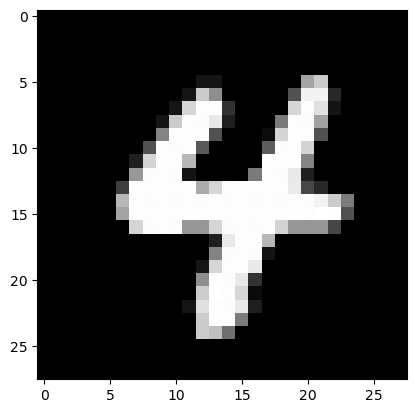

In [2]:
plt.imshow(test_set_no_mask[0][0], cmap='gray')